In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

import warnings
warnings.filterwarnings("ignore")


🔍 Step 1: Load & Understand the Dataset


In [2]:
# Load the dataset
df = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")

# Basic info
print("Shape:", df.shape)
print("\nData Types:\n", df.dtypes)
print("\nMissing Values:\n", df.isnull().sum())

# Preview
df.head()


Shape: (7043, 21)

Data Types:
 customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

Missing Values:
 customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract          

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


✅ Step 2: Exploratory Data Analysis (EDA)


Churn
No     5174
Yes    1869
Name: count, dtype: int64

Class distribution (%):
Churn
No     73.463013
Yes    26.536987
Name: proportion, dtype: float64


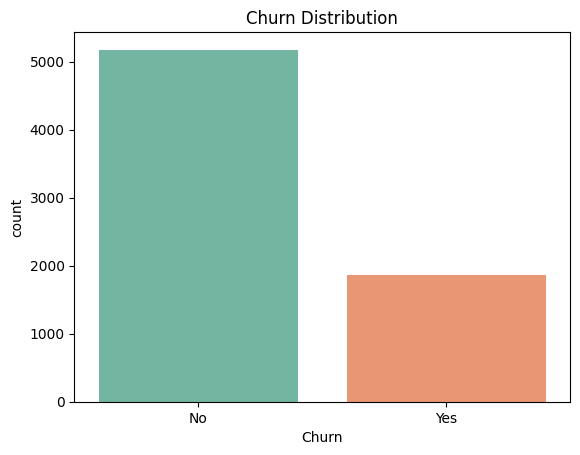

In [3]:
# Value counts and % of Churn
print(df['Churn'].value_counts())
print("\nClass distribution (%):")
print(df['Churn'].value_counts(normalize=True) * 100)

# Plot
sns.countplot(data=df, x='Churn', palette='Set2')
plt.title("Churn Distribution")
plt.show()


In [4]:
# Convert to numeric, coerce errors (bad values become NaN)
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Check new dtypes and missing values
print(df.dtypes)
print("\nMissing in TotalCharges:", df['TotalCharges'].isnull().sum())

# Drop rows with missing TotalCharges (only 11 rows)
df = df.dropna(subset=['TotalCharges'])

# Reset index
df.reset_index(drop=True, inplace=True)


customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
Churn                object
dtype: object

Missing in TotalCharges: 11


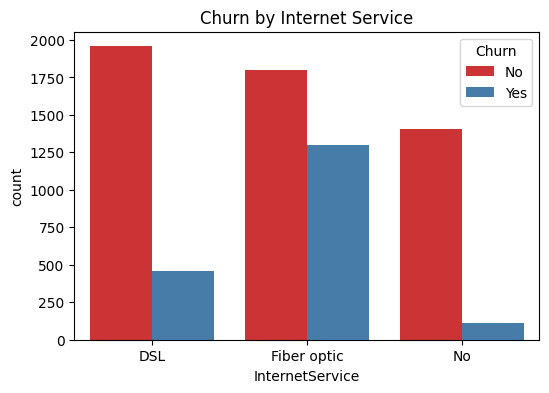

In [5]:
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='InternetService', hue='Churn', palette='Set1')
plt.title("Churn by Internet Service")
plt.show()


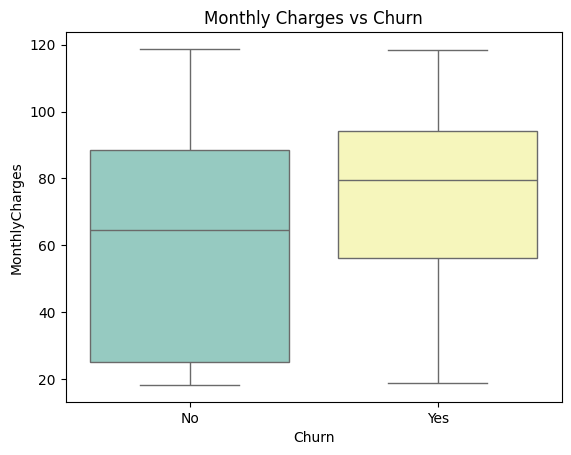

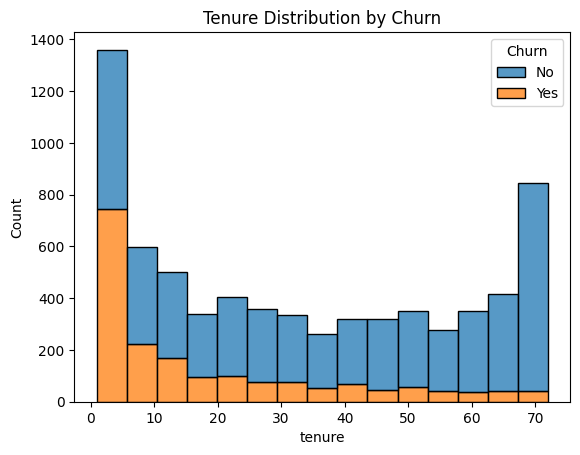

In [6]:
# Boxplot for MonthlyCharges
sns.boxplot(data=df, x='Churn', y='MonthlyCharges', palette='Set3')
plt.title("Monthly Charges vs Churn")
plt.show()

# Distribution of tenure
sns.histplot(data=df, x='tenure', hue='Churn', multiple='stack')
plt.title("Tenure Distribution by Churn")
plt.show()


✅ Step 3: Data Preprocessing


In [7]:
binary_cols = ['Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'Churn', 'gender']

# Replace Yes/No and Male/Female with 1/0
for col in binary_cols:
    df[col] = df[col].replace({'Yes': 1, 'No': 0, 'Male': 1, 'Female': 0})


In [8]:
multi_cat_cols = ['InternetService', 'MultipleLines', 'OnlineSecurity', 'OnlineBackup',
                  'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
                  'Contract', 'PaymentMethod']

df = pd.get_dummies(df, columns=multi_cat_cols, drop_first=True)


In [9]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
num_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
df[num_cols] = scaler.fit_transform(df[num_cols])


In [10]:
# Drop customerID
df.drop('customerID', axis=1, inplace=True)

# Define X and y
X = df.drop('Churn', axis=1)
y = df['Churn']

# Train-test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


✅ Step 4: Model Building & Evaluation


In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Train
lr_model = LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000)
lr_model.fit(X_train, y_train)

# Predict
y_pred_lr = lr_model.predict(X_test)
y_prob_lr = lr_model.predict_proba(X_test)[:, 1]

# Evaluate
print("🔹 Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred_lr))

print("🔹 Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_lr))

print("🔹 ROC-AUC Score:", roc_auc_score(y_test, y_prob_lr))


🔹 Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.70      0.79      1033
           1       0.49      0.79      0.61       374

    accuracy                           0.73      1407
   macro avg       0.70      0.75      0.70      1407
weighted avg       0.79      0.73      0.74      1407

🔹 Confusion Matrix:
[[724 309]
 [ 77 297]]
🔹 ROC-AUC Score: 0.8354579621164667


In [12]:
from sklearn.ensemble import RandomForestClassifier

# Train
rf_model = RandomForestClassifier(class_weight='balanced', random_state=42)
rf_model.fit(X_train, y_train)

# Predict
y_pred_rf = rf_model.predict(X_test)
y_prob_rf = rf_model.predict_proba(X_test)[:, 1]

# Evaluate
print("🔹 Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))

print("🔹 Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))

print("🔹 ROC-AUC Score:", roc_auc_score(y_test, y_prob_rf))


🔹 Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.90      0.86      1033
           1       0.64      0.49      0.56       374

    accuracy                           0.79      1407
   macro avg       0.73      0.70      0.71      1407
weighted avg       0.78      0.79      0.78      1407

🔹 Confusion Matrix:
[[928 105]
 [189 185]]
🔹 ROC-AUC Score: 0.8150188175243697


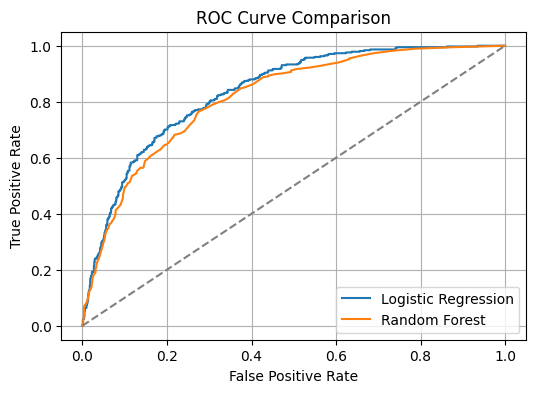

In [13]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

fpr_lr, tpr_lr, _ = roc_curve(y_test, y_prob_lr)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)

plt.figure(figsize=(6, 4))
plt.plot(fpr_lr, tpr_lr, label='Logistic Regression')
plt.plot(fpr_rf, tpr_rf, label='Random Forest')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.grid(True)
plt.show()


🔥 Step 5: Try XGBoost


In [14]:
pip install xgboost


In [15]:
from xgboost import XGBClassifier

# Train XGBoost with class weights
xgb_model = XGBClassifier(scale_pos_weight=2.77,  # 5174/1869 ≈ 2.77 (to balance class)
                          use_label_encoder=False,
                          eval_metric='logloss',
                          random_state=42)

xgb_model.fit(X_train, y_train)

# Predict
y_pred_xgb = xgb_model.predict(X_test)
y_prob_xgb = xgb_model.predict_proba(X_test)[:, 1]

# Evaluate
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

print("🔹 XGBoost Classification Report:")
print(classification_report(y_test, y_pred_xgb))

print("🔹 Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_xgb))

print("🔹 ROC-AUC Score:", roc_auc_score(y_test, y_prob_xgb))


🔹 XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.78      0.82      1033
           1       0.52      0.66      0.58       374

    accuracy                           0.75      1407
   macro avg       0.69      0.72      0.70      1407
weighted avg       0.77      0.75      0.76      1407

🔹 Confusion Matrix:
[[809 224]
 [128 246]]
🔹 ROC-AUC Score: 0.8146810339026045


📌 Feature Importance (XGBoost)


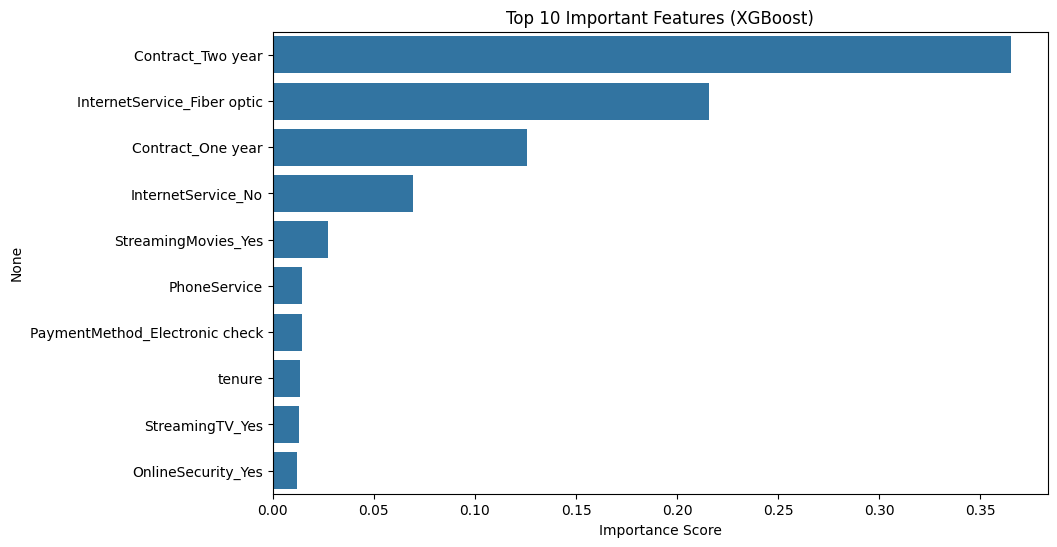

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Feature importances
xgb_importance = pd.Series(xgb_model.feature_importances_, index=X_train.columns)
xgb_importance = xgb_importance.sort_values(ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=xgb_importance.values[:10], y=xgb_importance.index[:10])
plt.title('Top 10 Important Features (XGBoost)')
plt.xlabel('Importance Score')
plt.show()


Step: XGBoost with Stratified K-Fold Cross-Validation


In [17]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
import numpy as np

# Prepare stratified KFold
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

roc_auc_scores = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X, y)):
    X_train_cv, X_val_cv = X.iloc[train_idx], X.iloc[val_idx]
    y_train_cv, y_val_cv = y.iloc[train_idx], y.iloc[val_idx]

    # Initialize model with same params as before
    model = XGBClassifier(scale_pos_weight=2.77,
                          use_label_encoder=False,
                          eval_metric='logloss',
                          random_state=42)

    # Train
    model.fit(X_train_cv, y_train_cv)

    # Predict probabilities
    y_val_pred_prob = model.predict_proba(X_val_cv)[:, 1]

    # Calculate ROC-AUC for this fold
    roc_auc = roc_auc_score(y_val_cv, y_val_pred_prob)
    roc_auc_scores.append(roc_auc)

    print(f"Fold {fold+1} ROC-AUC: {roc_auc:.4f}")

print(f"\nAverage ROC-AUC across 5 folds: {np.mean(roc_auc_scores):.4f} ± {np.std(roc_auc_scores):.4f}")


Fold 1 ROC-AUC: 0.8302
Fold 2 ROC-AUC: 0.8272
Fold 3 ROC-AUC: 0.8204
Fold 4 ROC-AUC: 0.8190
Fold 5 ROC-AUC: 0.8228

Average ROC-AUC across 5 folds: 0.8239 ± 0.0042
